In [79]:
# !pip install seaborn

### Import libraries

In [82]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
import os

from openpyxl.workbook import Workbook

# see all variables
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Optional: Set working directory to where your data and outputs will go
os.chdir(r"D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work")
# Ensure directories exist
os.makedirs("model_output", exist_ok=True)
os.makedirs("visualization", exist_ok=True)

### Load data

In [10]:
# Load your cleaned dataset
df_raw = pd.read_csv("D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/data/cleaned_df.csv")
df = df_raw.copy()
print(df.shape)
df.head(3)

(47405, 109)


,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,tb_status_derived_age,obese_status_derived_age,hiv_status_derived_age
0,000025C5-5811-4942-8957-8A1A4FF1460F,35,NaN,2,2008-07-26,Assess Linkages Main,Nairobi,0.0,NaN,NaN,NaN,0.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,-888.0,0.0,-888.0,-888.0,NaN,NaN,-888.0,2.0,1.0,-888.0,-888.0,NaN,NaN,12.0,-888.0,0.0,NaN,0.0,0.0,-888.0,NaN,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,99.0,58.0,4.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0,NaN,NaN,NaN,False,888,0.0,39.0,39.0,39.0,39.0,39.0,39.0
1,000025C5-5811-4942-8957-8A1A4FF1460F,39,NaN,2,2012-09-30,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,4.0,7.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-999.0,NaN,0,NaN,NaN,NaN,NaN,888.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.0,0,NaN,25.9187,25.9,False,0,0.0,39.0,39.0,39.0,39.0,39.0,39.0
2,0004A623-93CA-4D53-B10C-805B27EFD98F,36,NaN,1,2012-08-26,SCALEUP Population Baseline,Nairobi,NaN,0.0,NaN,NaN,0.0,888.0,NaN,NaN,NaN,2.0,NaN,NaN,7.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,-999.0,NaN,0,NaN,NaN,NaN,NaN,888.0,888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1.0,0,NaN,31.1690,31.2,False,0,0.0,36.0,36.0,36.0,36.0,36.0,36.0


### Data preprocessing

In [41]:
def assign_who_age_group_code(age):
    if pd.isnull(age):
        return 999  # 999 = Missing
    elif age < 15:
        return 1  # Children (0–14)
    elif age < 25:
        return 2  # Youth (15–24)
    elif age < 65:
        return 3  # Adults (25–64)
    else:
        return 4  # Elderly (65+)

# Apply the function to your DataFrame
df["age_group"] = df["age"].apply(assign_who_age_group_code)

# Optional: Map codes to readable labels
age_group_labels = {
    1: "Children (0–14)",
    2: "Youth (15–24)",
    3: "Adults (25–64)",
    4: "Elderly (65+)",
    999: "Missing"
}
df["who_age_group"] = df["age_group"].map(age_group_labels)

# ---------------------------------------------------------------------------
# Convert your numeric columns properly
df = df.apply(pd.to_numeric, errors='coerce')

# ---------------------------------------------------------------------------
# Exclude irrelevant values
df = df.replace([333, 444, 888, 999, -333, -444, -888, -999], np.nan)

df.head(3)

,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,tb_status_derived_age,obese_status_derived_age,hiv_status_derived_age,age_group,who_age_group,age_start,age_end,stroke_prev,event,time_at_risk,cumulative_stroke,offset
0,NaN,35,NaN,2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,12.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,99.0,58.0,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,False,NaN,0.0,39.0,39.0,39.0,39.0,39.0,39.0,3,NaN,35,39.0,NaN,0,4.0,0,1.386294
1,NaN,39,NaN,2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,7.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1.0,0.0,0.0,NaN,25.9187,25.9,False,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,3,NaN,39,NaN,0.0,0,2.0,0,0.693147
2,NaN,36,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,1.0,1.0,0.0,NaN,31.1690,31.2,False,0.0,0.0,36.0,36.0,36.0,36.0,36.0,36.0,3,NaN,36,NaN,NaN,0,2.0,0,0.693147


### Treatment to ensure we don't inflate incidence

In [15]:
print("Before")
print(df.shape)
df = df.sort_values(['individual_id', 'obs_date'])

# ---------------------------------------------------------------------------
# Sort and prepare time intervals
df['age_start'] = df.groupby('individual_id')['age'].shift(0)
df['age_end'] = df.groupby('individual_id')['age'].shift(-1)

# ---------------------------------------------------------------------------
# Define the event (stroke occurrence)
df['stroke_prev'] = df.groupby('individual_id')['stroke_status_derived'].shift(1)
df['event'] = np.where((df['stroke_prev'] == 0) & (df['stroke_status_derived'] == 1), 1, 0)
df['event'] = df['event'].fillna(0)

# ---------------------------------------------------------------------------
# Compute time at risk
df['time_at_risk'] = df['age_end'] - df['age_start']
df['time_at_risk'] = df['time_at_risk'].fillna(2)  # Filling with an average followup of 2 year / we can change this

# ---------------------------------------------------------------------------
# find first event per person  (different from prevalence)
df['cumulative_stroke'] = df.groupby('individual_id')['stroke_status_derived'].cumsum()

# ---------------------------------------------------------------------------
# keep only records before or up to the first stroke
df = df[df['cumulative_stroke'] <= 1]

print("after")
print(df.shape)

Before
(47405, 116)
after
(45842, 117)


### Create offset and covariates

In [18]:
df['offset'] = np.log(df['time_at_risk'])

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Covariates and dealing with infinite values

In [57]:
# How to deal with missing / infinite values before running the model
# # Option 1 (drop missing values)
# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.dropna()

# Option 2
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)  # or use .fillna(df.mean()) if numeric

covariates = ['sex', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived'
              ,'bmi_refined','hiv_status_derived', 'tb_status_derived']
# 'sex', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_refined','hiv_status_derived', 'tb_status_derived'


In [59]:
X = df[covariates]
y = df['stroke_status_derived']

X = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     stroke_status_derived   R-squared:                       0.010
Model:                               OLS   Adj. R-squared:                  0.010
Method:                    Least Squares   F-statistic:                     51.58
Date:                   Mon, 06 Oct 2025   Prob (F-statistic):           8.08e-94
Time:                           11:58:43   Log-Likelihood:                 21356.
No. Observations:                  45842   AIC:                        -4.269e+04
Df Residuals:                      45832   BIC:                        -4.260e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

In [34]:
import numpy as np
import pandas as pd

# Check for NaN or inf
df.isna().sum()  # counts NaNs per column
np.isinf(df).sum()  # counts infinities per column

# Quick way to see how many bad values per column
(df.isna() | np.isinf(df)).sum()

individual_id        45842
age                      0
dod                  45842
sex                      0
obs_date             45842
                     ...  
stroke_prev          25486
event                    0
time_at_risk             0
cumulative_stroke        0
offset                3397
Length: 118, dtype: int64

### Poisson regression model

In [62]:
import statsmodels.api as sm

model_pois = sm.GLM(
    df['event'],
    sm.add_constant(df[covariates]),
    family=sm.families.Poisson(),
    offset=df['offset']
).fit()

print(model_pois.summary())
print("\nIncidence Rate Ratios (IRR):")
print(np.exp(model_pois.params))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                45842
Model:                            GLM   Df Residuals:                    45832
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3243.7
Date:                Mon, 06 Oct 2025   Deviance:                       5233.4
Time:                        12:19:00   Pearson chi2:                 5.93e+04
No. Iterations:                    11   Pseudo R-squ. (CS):            0.01125
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.3686 

#### Poisson Model Results

In [64]:
import numpy as np
import pandas as pd

# Print full model summary
print(model_pois.summary())

# Create a tidy summary DataFrame
results_df = pd.DataFrame({
    "Variable": model_pois.params.index,
    "Coef": model_pois.params.values,
    "StdErr": model_pois.bse,
    "z": model_pois.tvalues,
    "P>|z|": model_pois.pvalues,
    "CI_lower": model_pois.conf_int()[0],
    "CI_upper": model_pois.conf_int()[1]
})

# Add Incidence Rate Ratios (IRR)
results_df["IRR"] = np.exp(results_df["Coef"])
results_df["IRR_CI_lower"] = np.exp(results_df["CI_lower"])
results_df["IRR_CI_upper"] = np.exp(results_df["CI_upper"])

# print(results_df)
results_df.to_csv("model_output/poisson_model_results.csv", index=False)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                45842
Model:                            GLM   Df Residuals:                    45832
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3243.7
Date:                Mon, 06 Oct 2025   Deviance:                       5233.4
Time:                        12:21:01   Pearson chi2:                 5.93e+04
No. Iterations:                    11   Pseudo R-squ. (CS):            0.01125
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -6.3686 

#### Trying something

In [70]:
# Dependent variable (binary or count of strokes)
y = df['event']

# Independent variables (add or remove as appropriate)
X = df[['sex', 'alcohol_use', 'tobacco_use', 'hpt_status_derived',
         'obese_status_derived', 'diab_status_derived',
         'bmi_refined', 'hiv_status_derived', 'tb_status_derived']]

# Add constant
X = sm.add_constant(X)

### Three models

#### Standard Poisson Regression

In [71]:
model_pois = sm.GLM(y, X, family=sm.families.Poisson()).fit()
model_robust = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type='HC0')
model_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

#### Compare models side-by-side

In [74]:
summary = summary_col(
    results=[model_pois, model_robust, model_nb],
    model_names=['Poisson', 'Robust Poisson', 'NegBinomial'],
    stars=True,
    float_format='%0.3f',
    info_dict={'N':lambda x: f"{int(x.nobs)}"}
)
print(summary)


                      Poisson  Robust Poisson NegBinomial
---------------------------------------------------------
const                -5.445*** -5.445***      -5.468***  
                     (0.179)   (0.177)        (0.181)    
sex                  -0.316*** -0.316***      -0.318***  
                     (0.081)   (0.081)        (0.082)    
alcohol_use          -0.640*** -0.640***      -0.643***  
                     (0.154)   (0.153)        (0.155)    
tobacco_use          0.019     0.019          0.020      
                     (0.106)   (0.103)        (0.107)    
hpt_status_derived   1.329***  1.329***       1.320***   
                     (0.132)   (0.134)        (0.133)    
obese_status_derived -0.350*** -0.350***      -0.378***  
                     (0.104)   (0.099)        (0.106)    
diab_status_derived  0.828***  0.828***       0.826***   
                     (0.092)   (0.091)        (0.094)    
bmi_refined          0.026***  0.026***       0.028***   
             

####  Compute and export IRRs for each model

In [83]:
def extract_irrs(model):
    df = pd.DataFrame({
        "Variable": model.params.index,
        "Coef": model.params.values,
        "StdErr": model.bse,
        "z": model.tvalues,
        "P>|z|": model.pvalues,
        "CI_lower": model.conf_int()[0],
        "CI_upper": model.conf_int()[1]
    })
    df["IRR"] = np.exp(df["Coef"])
    df["IRR_CI_lower"] = np.exp(df["CI_lower"])
    df["IRR_CI_upper"] = np.exp(df["CI_upper"])
    # Add significance stars
    df["sig"] = df["P>|z|"].apply(lambda p: 
                                  "***" if p < 0.001 else 
                                  "**" if p < 0.01 else 
                                  "*" if p < 0.05 else "")
    return df

results_pois = extract_irrs(model_pois)
results_robust = extract_irrs(model_robust)
results_nb = extract_irrs(model_nb)

# --- 4️⃣ Combine results for export ---
all_results = pd.concat([
    results_pois.assign(Model='Poisson'),
    results_robust.assign(Model='Robust Poisson'),
    results_nb.assign(Model='NegBinomial')
])

# Save table to Excel
all_results.to_excel("model_output/stroke_model_results_comparison.xlsx", index=False)
print("✅ Model comparison results saved to Excel.")

✅ Model comparison results saved to Excel.


#### Visualize

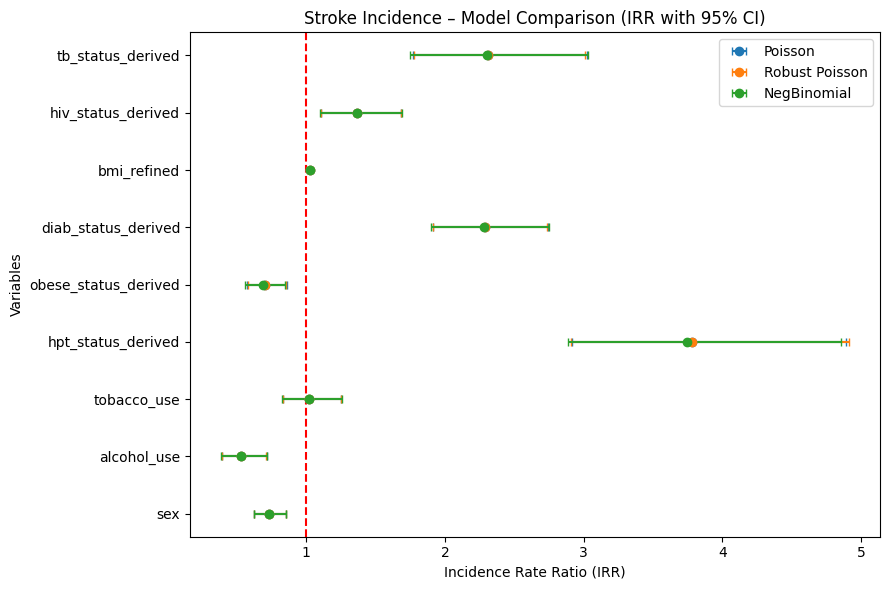

In [85]:
plt.figure(figsize=(9, 6))
for model_name, df in [('Poisson', results_pois),
                       ('Robust Poisson', results_robust),
                       ('NegBinomial', results_nb)]:
    plot_df = df[df["Variable"] != "const"]
    plt.errorbar(
        plot_df["IRR"], plot_df["Variable"],
        xerr=[plot_df["IRR"] - plot_df["IRR_CI_lower"], 
              plot_df["IRR_CI_upper"] - plot_df["IRR"]],
        fmt='o', capsize=3, label=model_name
    )

plt.axvline(1, color='red', linestyle='--')
plt.xlabel("Incidence Rate Ratio (IRR)")
plt.ylabel("Variables")
plt.title("Stroke Incidence – Model Comparison (IRR with 95% CI)")
plt.legend()
plt.tight_layout()
plt.savefig('visualization/stroke_model_comparison.png', dpi=300)
plt.show()

#### Second visual

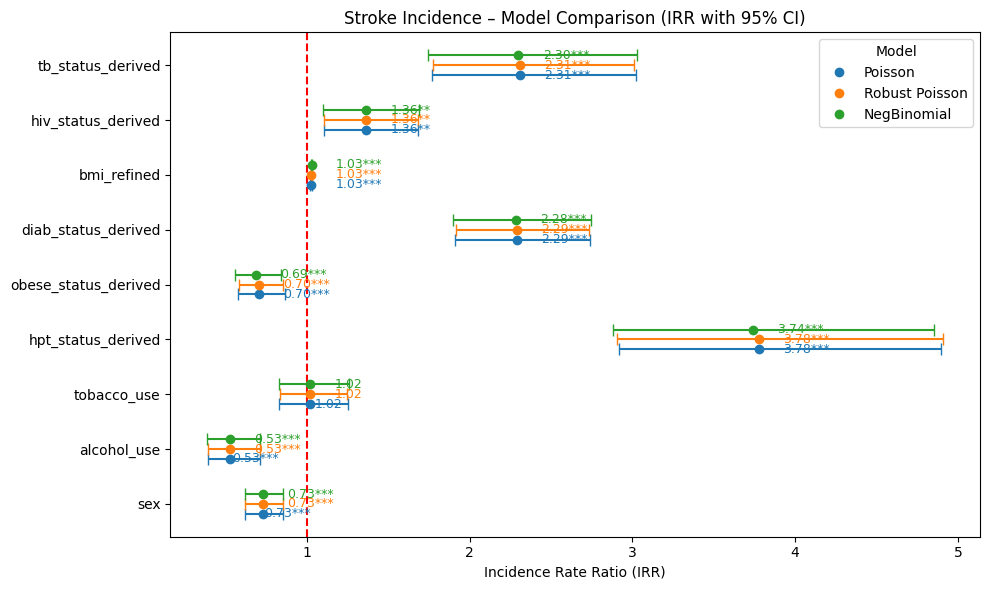

Saved: visualization/stroke_model_comparison_annotated_fixed.png


In [88]:
import numpy as np
import matplotlib.pyplot as plt

# --- prepare a base variable order (use Poisson result as reference) ---
varlist = results_pois.loc[results_pois["Variable"] != "const", "Variable"].tolist()
n_vars = len(varlist)
base_y = np.arange(n_vars)

# vertical offsets so the 3 model points don't overlap
y_offsets = {
    'Poisson': -0.18,
    'Robust Poisson': 0.0,
    'NegBinomial': 0.18
}

colors = {
    'Poisson': '#1f77b4',
    'Robust Poisson': '#ff7f0e',
    'NegBinomial': '#2ca02c'
}

plt.figure(figsize=(10, 6))

# loop over models and plot
for model_name, df in [
    ('Poisson', results_pois),
    ('Robust Poisson', results_robust),
    ('NegBinomial', results_nb)
]:
    # align to varlist so positions are consistent
    df_aligned = df.set_index('Variable').reindex(varlist).reset_index()

    for j, row in df_aligned.iterrows():
        # skip variables with missing estimates
        if pd.isna(row['IRR']):
            continue

        y = base_y[j] + y_offsets[model_name]

        # compute left/right error for errorbar
        left = row['IRR'] - row['IRR_CI_lower']
        right = row['IRR_CI_upper'] - row['IRR']

        # Plot errorbar and point
        plt.errorbar(
            x=row['IRR'],
            y=y,
            xerr=np.array([[left], [right]]),
            fmt='o',
            capsize=4,
            color=colors[model_name],
            label=None  # legend handled below
        )

        # Add IRR text + significance star to the right of the point
        text_offset = 0.03 * (plt.xlim()[1] - plt.xlim()[0]) if plt.xlim()[1] > plt.xlim()[0] else 0.05
        # to avoid referencing plt.xlim() before any points are drawn, use a small constant fallback:
        if text_offset == 0:
            text_offset = 0.05
        plt.text(row['IRR'] + text_offset, y, f'{row["IRR"]:.2f}{row.get("sig","")}',
                 fontsize=9, color=colors[model_name], va='center')

# Add a manual legend (one marker per model)
for mn, color in colors.items():
    plt.plot([], [], 'o', color=color, label=mn)
plt.legend(title='Model')

# y-ticks and labels
plt.yticks(base_y, varlist)
plt.axvline(1, color='red', linestyle='--')
plt.xlabel("Incidence Rate Ratio (IRR)")
plt.title("Stroke Incidence – Model Comparison (IRR with 95% CI)")
plt.tight_layout()

# Save and show
plt.savefig('visualization/stroke_model_comparison_annotated_fixed.png', dpi=300)
plt.show()
print("Saved: visualization/stroke_model_comparison_annotated_fixed.png")

### Checking for overdispersion

In [89]:
deviance = model_pois.deviance
df_resid = model_pois.df_resid
dispersion = deviance / df_resid
print("Dispersion parameter:", dispersion)

if dispersion > 1.5:
    print("⚠️ Data likely overdispersed — Negative Binomial model may be more appropriate.")
else:
    print("✅ Poisson model dispersion acceptable.")

Dispersion parameter: 0.10658135270111493
✅ Poisson model dispersion acceptable.
